# Identifying Fraudulent Activities

Company XYZ is an e-commerce site that sells hand-made clothes. You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists. You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

# Load, Investigate and Clean Data

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

In [2]:
# Load CSV files
ip = pd.read_csv('IpAddress_to_Country.csv')
user = pd.read_csv('Fraud_Data.csv')

In [3]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
countries = []
for i in range(len(user)):
    ip_address = user['ip_address'][i]
    tmp = ip[(ip['lower_bound_ip_address'] <= ip_address) &
                          (ip['upper_bound_ip_address'] >= ip_address)]  ## return boolean False & True under lower/upper_bound ip address
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('unknown')

In [5]:
user['country'] = countries  # Adding a new column 'country' to the DataFrame user
user.to_csv('fraudulent_data_with_country.csv', index=False)  # Saving the DataFrame to CSV

In [6]:
df = pd.read_csv('fraudulent_data_with_country.csv')

In [7]:
df.country.value_counts()

United States                    58049
unknown                          21966
China                            12038
Japan                             7306
United Kingdom                    4490
                                 ...  
San Marino                           1
Yemen                                1
Bonaire; Sint Eustatius; Saba        1
Turkmenistan                         1
Madagascar                           1
Name: country, Length: 182, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [9]:
df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


## data engineering

In [10]:
# suspicious if a user to signup and purchase an item very soon 
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

df['diff_time'] = (df['purchase_time'] - df['signup_time'])/np.timedelta64(1, 's')

df.drop(["signup_time", "purchase_time"], axis=1, inplace=True)

In [11]:
# suspicious if a user share many devices
num_dev_shared = df.device_id.value_counts()

df['num_dev_shared'] = df.device_id.map(num_dev_shared)
df.drop(["device_id"], axis=1, inplace=True)

In [12]:
# suspicious if a user share many of the same ip address
num_ip_shared = df.ip_address.value_counts()

df['num_ip_shared'] = df.ip_address.map(num_ip_shared)
df.drop(["ip_address"], axis=1, inplace=True)

In [13]:
# how many users are from the same country
num_country_shared = df.country.value_counts()

# the less visit from a country, the more suspicious
df['num_country_shared'] = df.country.map(num_country_shared)
df.drop(["country"], axis=1, inplace=True)

In [14]:
# seems evenly distributed
df.source.value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [15]:
# seems evenly distributed except Opera
df.browser.value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

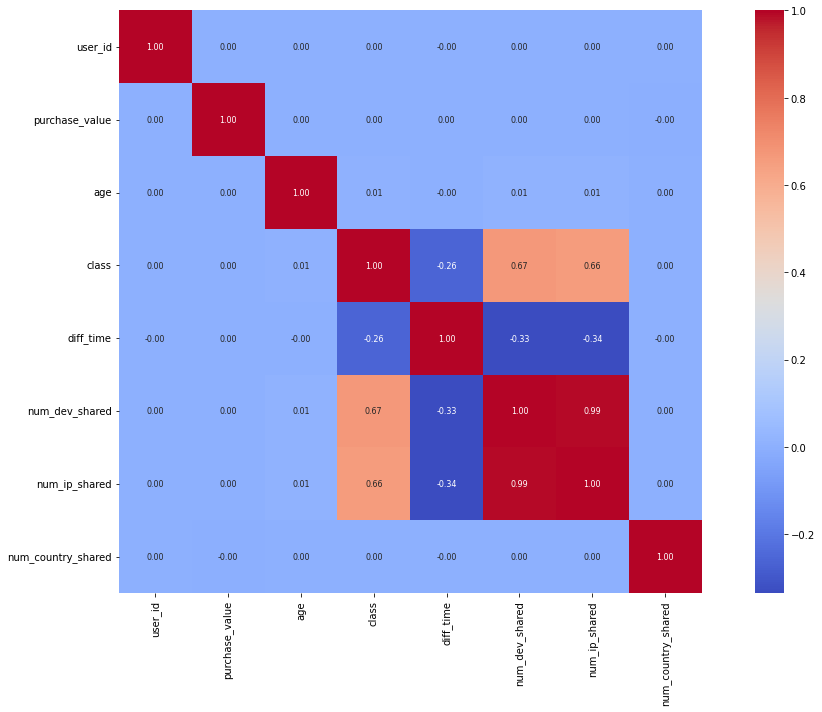

In [16]:
# there is a moderate postive correlation between class vs num_dev_shared and num_ip_shared 
# there is a perfect correlation between num_dev_shared vs num_ip_shared 
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, fmt='.2f', square=True, linecolor='white', cmap='coolwarm', vmax=1.0, annot=True,annot_kws={'size':8.0});
plt.tight_layout()

# Preparing Data

In [17]:
# importing required packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [18]:
df_clean = df.copy()

## 1. Standardization

In [19]:
# standardize Time and Amount columns
# standardization aims to improve performance measures of machine learning methods
std_scaler = StandardScaler()
df_clean['std_value'] = std_scaler.fit_transform(df_clean['purchase_value'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['diff_time'].values.reshape(-1, 1))
df_clean.drop(['diff_time', 'purchase_value', 'user_id'], axis=1, inplace=True)

## 2. Dummy Variables

In [20]:
df_clean

,source,browser,sex,age,class,num_dev_shared,num_ip_shared,num_country_shared,std_value,std_time
0,SEO,Chrome,M,39,0,1,1,7306,-0.160204,-0.136044
1,Ads,Chrome,F,53,0,1,1,58049,-1.142592,-1.571878
2,SEO,Opera,M,53,1,12,12,58049,-1.197169,-1.577617
3,SEO,Safari,M,41,0,1,1,21966,0.385567,-1.420221
4,Ads,Safari,M,45,0,1,1,58049,0.112681,-0.182509
...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,1,2,1,58049,0.330990,0.105299
151108,SEO,Safari,M,32,0,1,1,1680,-0.105627,-1.279733
151109,SEO,IE,F,26,0,1,1,7306,0.167258,0.559638
151110,SEO,Chrome,M,37,0,2,1,58049,0.494721,0.068469


In [21]:
## Label Encoding
lb_make = LabelEncoder()
df_clean['source'] = lb_make.fit_transform(df['source'])
df_clean['browser'] = lb_make.fit_transform(df['browser'])
df_clean['sex'] = lb_make.fit_transform(df['sex'])

In [22]:
df_enc = df_clean.copy()
df_enc

,source,browser,sex,age,class,num_dev_shared,num_ip_shared,num_country_shared,std_value,std_time
0,2,0,1,39,0,1,1,7306,-0.160204,-0.136044
1,0,0,0,53,0,1,1,58049,-1.142592,-1.571878
2,2,3,1,53,1,12,12,58049,-1.197169,-1.577617
3,2,4,1,41,0,1,1,21966,0.385567,-1.420221
4,0,4,1,45,0,1,1,58049,0.112681,-0.182509
...,...,...,...,...,...,...,...,...,...,...
151107,2,0,1,28,1,2,1,58049,0.330990,0.105299
151108,2,4,1,32,0,1,1,1680,-0.105627,-1.279733
151109,2,2,0,26,0,1,1,7306,0.167258,0.559638
151110,2,0,1,37,0,2,1,58049,0.494721,0.068469


## 3. Splitting into training, validation, and test set

In [23]:
# Isolate X variables
X = df_enc.drop('class', axis=1)

# Isolate y variable
y = df_enc['class']

# Split into train and test sets
X_interim, X_test, y_interim, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_interim, y_interim, test_size=0.25, stratify=y_interim, random_state=42)

### 4. Model Imbalance

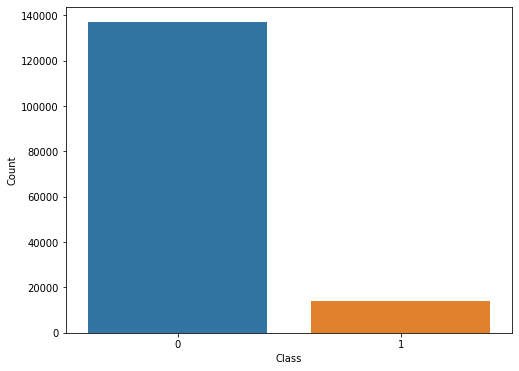

0    136961
1     14151
Name: class, dtype: int64


In [24]:
# Count the values in the 'class' column
class_counts = df_enc['class'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df_enc)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display the class counts
print(class_counts)

1    8491
0    8491
Name: class, dtype: int64


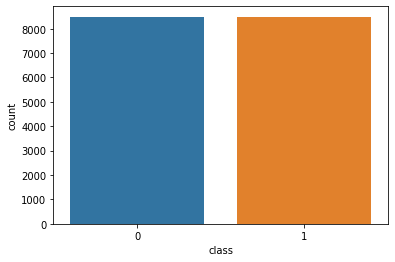

In [25]:
# Using the under-sampling technique
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# check balancing of the classes
print(y_rus.value_counts())

# plotting the new distribution of the classess
sns.countplot(x = y_rus);

# Modeling

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, 
                             accuracy_score, precision_recall_fscore_support,
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay)

from sklearn.model_selection import GridSearchCV

## 1. Logistic Regression Model

In [27]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42,max_iter=500).fit(X_rus,y_rus)
y_pred = log_clf.predict(X_test)

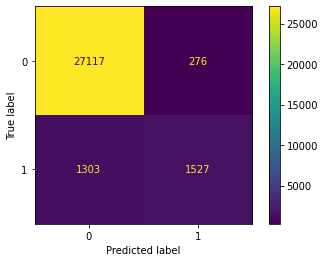

In [28]:
# Compute values for confusion matrix
log_cm  = confusion_matrix(y_test,y_pred,labels = log_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=log_clf.classes_)

log_disp.plot(values_format='')

plt.show()

In [29]:
# Create classification report for logistic regression model
target_names = ['not fraud','fraud']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   not fraud       0.95      0.99      0.97     27393
       fraud       0.85      0.54      0.66      2830

    accuracy                           0.95     30223
   macro avg       0.90      0.76      0.82     30223
weighted avg       0.94      0.95      0.94     30223



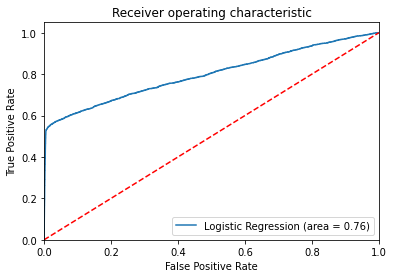

In [30]:
logit_roc_auc = roc_auc_score(y_test, log_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
# Calculate predicted probabilities for the positive class
y_probs = log_clf.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_probs)

# Find the optimal cutoff point (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Print the optimal threshold and AUC
print("Optimal Threshold:", optimal_threshold)
print("AUC:", auc)

Optimal Threshold: 0.47180916143341134
AUC: 0.7985967630687418


In [32]:
# Rebuild the model with the optimal cutoff point
y_pred_optimal = np.where(y_probs >= optimal_threshold, 1, 0)

# Generate classification report
classification_report_optimal = classification_report(y_test, y_pred_optimal)

# Print the classification report
print(classification_report_optimal)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     27393
           1       0.75      0.56      0.64      2830

    accuracy                           0.94     30223
   macro avg       0.85      0.77      0.80     30223
weighted avg       0.94      0.94      0.94     30223



We should focus on choosing a relatively higher threshold because false negative's cost is much higher since company will lose money directly if we classify Fruad as not Fruad.

In [56]:
# Rebuild the model with the optimal cutoff point
y_pred_optimal = np.where(y_probs >= 0.59, 1, 0)

# Generate classification report
classification_report_manual = classification_report(y_test, y_pred_optimal)

# Print the classification report
print(classification_report_manual)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.91      0.53      0.67      2830

    accuracy                           0.95     30223
   macro avg       0.93      0.76      0.82     30223
weighted avg       0.95      0.95      0.94     30223



## 2. Tree

### 2.1 Decision Tree Classifier

In [47]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy
  
    Returns a pandas df with the F1, recall, precision, and accuracy
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                        })
  
    return table

In [34]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='recall')

In [35]:
%%time
tree1.fit(X_rus,y_rus)

Wall time: 4.49 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='recall', scoring={'recall', 'accuracy', 'f1', 'precision'})

In [36]:
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [41]:
tree1_results_cv = make_results('decision tree cv', tree1, 'recall')
tree1_results_cv

,model,precision,recall,F1,accuracy
0,decision tree cv,0.720905,0.737252,0.72897,0.725886


### 2.2 Random Forest Classifier

In [42]:
# Instantiate model
rf = RandomForestClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2],
             'min_samples_split': [3,4],
             'n_estimators': [300, 500],
             }  
# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}


# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [43]:
%%time
rf1.fit(X_rus,y_rus)

Wall time: 6min 24s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [3, 4],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'recall', 'accuracy', 'f1', 'precision'})

In [44]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 300}

In [48]:
rf1_results_cv = make_results('random forest cv', rf1, 'recall')
rf1_results_cv

,model,precision,recall,F1,accuracy
0,random forest cv,0.91791,0.714993,0.803834,0.825521


### 2.3 XGBoost

In [49]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [50]:
%%time
xgb_cv.fit(X_rus, y_rus)

Wall time: 3min 33s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [51]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

In [54]:
xgb_results_cv = make_results('xgb cv', xgb_cv, 'recall')
xgb_results_cv

,model,precision,recall,F1,accuracy
0,xgb cv,0.917892,0.714758,0.803677,0.825404


In [57]:
print(tree1_results_cv)
print()
print(rf1_results_cv)
print()
print(xgb_results_cv)

              model  precision    recall       F1  accuracy
0  decision tree cv   0.720905  0.737252  0.72897  0.725886

              model  precision    recall        F1  accuracy
0  random forest cv    0.91791  0.714993  0.803834  0.825521

    model  precision    recall        F1  accuracy
0  xgb cv   0.917892  0.714758  0.803677  0.825404


Our top-performing model, which employs random forest with cross-validation (RF CV), outperforms the decision tree model, particularly in terms of accuracy and precision. Despite placing greater importance on recall, the RF CV model demonstrates significantly higher precision, making it the preferable choice.

# Evaluate champ model

In [71]:
# Compute the predicted values for champion model
champ_pred = rf1.predict(X_test)

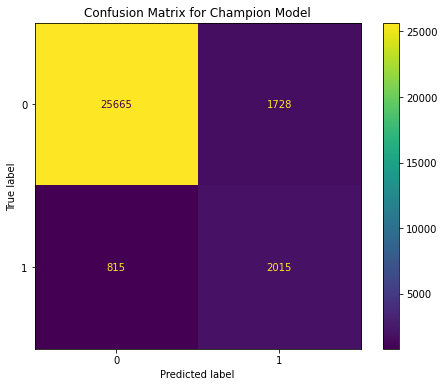

In [72]:
# Display the confusion matrix
ch_cm = confusion_matrix(y_test, champ_pred, labels=rf1.classes_)

# Create display of confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=ch_cm, display_labels=rf1.classes_).plot(ax=ax)
ax.set_title("Confusion Matrix for Champion Model")

# Plot confusion matrix
plt.grid(False)

# Display plot
plt.show()

In [73]:
# Compute the metrics
champ_accuracy = accuracy_score(y_test, champ_pred)
champ_precision = precision_score(y_test, champ_pred)
champ_recall = recall_score(y_test, champ_pred)
champ_f1 = f1_score(y_test,champ_pred)

champ_table = pd.DataFrame({"Model":"Tuned Random Forest",
                        "F1":[champ_f1],
                        "Precision":[champ_precision],
                        "Recall":[champ_recall],
                        "Accuracy":[champ_accuracy]})
champ_table

,Model,F1,Precision,Recall,Accuracy
0,Tuned Random Forest,0.613114,0.538338,0.712014,0.915859


In [87]:
# Look at feature importance
importances = rf1.best_estimator_.feature_importances_
importance_df = pd.DataFrame({"Feature":X_test.columns, "Importance":importances})
importance_df.sort_values(by='Importance', ascending=False,inplace=True)

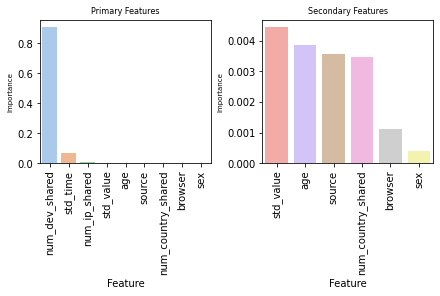

In [93]:
colors = sns.color_palette('pastel',len(importance_df.Feature))
fig, (a0, a1) = plt.subplots(figsize=(6,4),ncols=2,constrained_layout = True)
sns.barplot(x="Feature", y="Importance",data=importance_df,ax=a0,palette=colors)
a0.set_xticklabels(labels=importance_df['Feature'],rotation=90)
a0.set_title("Primary Features",fontsize=8)
a0.set_ylabel("Importance",fontsize=7)

sns.barplot(x="Feature", y="Importance",data=df_drop,ax=a1,palette=colors[3:])
a1.set_xticklabels(labels=df_drop['Feature'],rotation=90)
a1.set_title("Secondary Features",fontsize=8)
a1.set_ylabel("Importance",fontsize=7)
plt.show();

# Summary

The random forest model exhibited subpar accuracy in fraud classification. Our analysis indicates that the number of devices used and the time interval between signup and purchase are the two most influential features in predicting fraudulent activities. Surprisingly, the number of shared IP addresses did not rank highly in terms of feature importance.

Considering these findings, I propose experimenting with the inclusion of days of the week as features, removing standardization to assess the model's performance, and use oversampling instead of undersampling for data imbalance to capture more samples.